### Grading Feedback
102%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [16]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [17]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.ml.feature import StopWordsRemover, RegexTokenizer, IDF, CountVectorizer, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
import requests


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Question 1
Using the get_training_filename function defined in the cell above, read the sms_spam.csv file into a spark dataframe named spam_df.  There should be no empty columns in spam_df.

In [18]:
# Your code here
spam_df = spark.read.csv(get_training_filename("sms_spam.csv"), header=True)
spam_df.show(5)

+----+--------------------+
|type|                text|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
+----+--------------------+
only showing top 5 rows



### Grading Feedback

# Question 2
Starting with spam_df, create a new dataframe named spam_df1.  Rename the spam_df type column to be named spam.  In the spam column, replace the string `spam` the with the integer 1 and the string `ham` with the integer 0.  Print the head and shape of spam_df1.

In [19]:
# your code here
spam_df1 = spam_df.select(fn.when(fn.col('type') == 'spam',1).otherwise(0).alias(str('spam')), 'text')
print("shape:",(spam_df1.count(), len(spam_df1.columns)))
spam_df1.toPandas().head(5)

shape: (5574, 2)


,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Question 3
Starting with spam_df1, create a new dataframe named spam_df2 with a new column named filtered_text by removing stop words from the text column in spam_df.  Print the head and shape of spam_df2.

In [20]:
# your code here
sw = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

token = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("text").setOutputCol("words")
stop_filter = StopWordsRemover().setStopWords(sw).setCaseSensitive(False).setInputCol("words")\
            .setOutputCol("filtered_text")
pipe_stop = Pipeline(stages=[token, stop_filter]).fit(spam_df1)
spam_df2 = pipe_stop.transform(spam_df1)
spam_df2 = spam_df2.drop('words')
print('Shape: ',(spam_df2.count(),len(spam_df2.columns)))
spam_df2.toPandas().head(5)

Shape:  (5574, 3)


,spam,text,filtered_text
0,0,"Go until jurong point, crazy.. Available only ...","[jurong, point, crazy, available, bugis, n, gr..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, don, t, think, goes, usf, lives]"


### Grading Feedback

# Question 3
Create a new dataframe named spam_df3 starting with spam_df2.  Create a new column named tfidf by performing a term frequency / inverse document frequency transformation on the filtered_text column of spam_df2.<br>  

- Print the head and shape of spam_df3.  
- Print the top 10 most important words indicated by the TFIDF score.  
- Print the 10 least important words as indicated by the TFIDF score.
- Print the total number of columns in the TFIDF data in spam_df3
- Print the number of rows in the TFIDF data in spam_df3
- Based only on the number of rows and columns in the TFIDF data, do you expect the model to overfit.  Explain your answer.

In [21]:
# Your code here

count = CountVectorizer().setInputCol('filtered_text').setOutputCol('feature')
term = IDF().setInputCol("feature").setOutputCol("tfidf")

spam_df3 = spam_df2

tf_idf = Pipeline(stages=[count, term])
tf_transform = tf_idf.fit(spam_df3)
spam_df3 = tf_transform.transform(spam_df3)
spam_df3 = spam_df3.drop("feature")

print(spam_df3.toPandas().head())
print("Shape:",(spam_df3.count(), len(spam_df3.columns)))
vocabulary = tf_transform.stages[0].vocabulary
tfidf_val = tf_transform.stages[1].idf.tolist()
imp_words = {}
for i in range(len(vocabulary)):
    imp_words[vocabulary[i]] = tfidf_val[i]
tf_most_imp = sorted(imp_words.items(), key=lambda i: i[1], reverse=True)[0:10]
tf_less_imp = sorted(imp_words.items(), key=lambda i: i[1], reverse=False)[0:10]
print("Most important words:")
for i in range(10):
    print(i + 1, ". Word: ", tf_most_imp[i][0], ", ", "tfidf score: ", tf_most_imp[i][1])
print("Least important words:")
for i in range(10):
    print(i + 1, ". Word: ", tf_less_imp[i][0], ", ", "tfidf score: ", tf_less_imp[i][1])  
spam_df3.show(5)
print("No. of rows:", spam_df3.select('tfidf').count())
print("No. of columns:", len(tf_transform.stages[0].vocabulary))


   spam                                               text  \
0     0  Go until jurong point, crazy.. Available only ...   
1     0                      Ok lar... Joking wif u oni...   
2     1  Free entry in 2 a wkly comp to win FA Cup fina...   
3     0  U dun say so early hor... U c already then say...   
4     0  Nah I don't think he goes to usf, he lives aro...   

                                       filtered_text  \
0  [jurong, point, crazy, available, bugis, n, gr...   
1                     [ok, lar, joking, wif, u, oni]   
2  [free, entry, wkly, comp, win, fa, cup, final,...   
3               [u, dun, say, early, hor, u, c, say]   
4             [nah, don, t, think, goes, usf, lives]   

                                               tfidf  
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  (1.8914559363553713, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  (0.0, 4.732932264526793, 2.6026000033672867, 0...  
3  (3.7829118727107427, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  (0.0, 0.0, 2

Your model overfit explanation here: Here number of rows is 5574 and number of columns is 7443. As columns > rows the model will overfit.

### Grading Feedback

# Question 4
Create a pipeline named pipe1 capable of predicting ham or spam using logistic regression using spam_df3 as input data.

In [22]:
# your code here
lr = LogisticRegression().setLabelCol('spam').setFeaturesCol('tfidf').setRegParam(0.0).setMaxIter(100).setElasticNetParam(0.)

pipe1 = Pipeline(stages=[lr])
pipe1_trans = pipe1.fit(spam_df3)
pipe1_trans.transform(spam_df3).show(5)

+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|spam|                text|       filtered_text|               tfidf|       rawPrediction|         probability|prediction|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   0|Go until jurong p...|[jurong, point, c...|(7443,[15,26,52,6...|[46.4832509984271...|[1.0,6.4950214616...|       0.0|
|   0|Ok lar... Joking ...|[ok, lar, joking,...|(7443,[0,8,216,32...|[37.0230287333609...|[1.0,8.3387877120...|       0.0|
|   1|Free entry in 2 a...|[free, entry, wkl...|(7443,[1,2,9,21,2...|[-25.376984268883...|[9.52611378547952...|       1.0|
|   0|U dun say so earl...|[u, dun, say, ear...|(7443,[0,50,75,13...|[43.4350408188821...|[1.0,1.3689937049...|       0.0|
|   0|Nah I don't think...|[nah, don, t, thi...|(7443,[2,30,46,33...|[37.2489681189668...|[1.0,6.6524051231...|       0.0|
+----+----------

### Grading Feedback

# Question 5
Fit pipe1 using a [CrossValidator](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) object with the number of cross validation folds = 3.  Score the model using a [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html) using ROC AUC as the metric.  Name the cross validator object cv1 and the fitted cross validator object fitted_cv1.

In [23]:
# your code here
grid = ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator(labelCol='spam', metricName='areaUnderROC')
cv1 = CrossValidator(estimator=pipe1, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=60)
fitted_cv1 = cv1.fit(spam_df3)

### Grading Feedback

# Question 6
Print the cross validation AUC score from fitted_cv1.

In [24]:
# your code here
print("Area under ROC Curve:",evaluator.evaluate(fitted_cv1.transform(spam_df3)))

Area under ROC Curve: 1.0


### Grading Feedback

# Question 7
Create a ROC scatter plot from fitted_pipe1 TPR/FPR data.

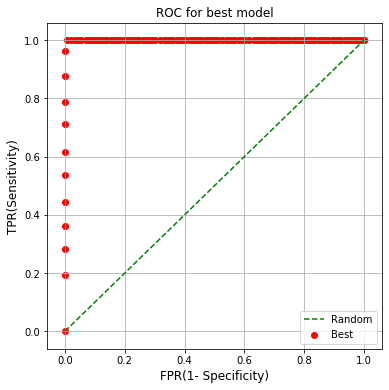

In [25]:
# your code here

roc_scatter = fitted_cv1.bestModel.stages[0].summary.roc
plt.figure(figsize=(6, 6))
plt.scatter(roc_scatter.select('FPR').collect(), roc_scatter.select('TPR').collect(), label='Best',color='Red')
plt.plot([0, 1], [0, 1],linestyle='--', label='Random',color='Green')                                 
plt.xlabel('FPR(1- Specificity)', fontsize=12)
plt.ylabel('TPR(Sensitivity)', fontsize=12) 
plt.title('ROC for best model')
plt.legend()
plt.grid(True)  
plt.show()

### Grading Feedback
Nice plot!

# Question 8
Create a new cross validator object named cv2 similar to cv1 but this time add a ParamGridBuilder.  Define a grid of elastic net regularization parameters. Fit cv2 and name the resulting fitted cross validator fitted_cv2.  The number of parameters in your grid should be limited such that it runs in a reasonable amount of time (around 5 to 10 minutes max).  

In [26]:
# your code here
grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.03]).addGrid(lr.elasticNetParam, [0.04, 0.08, 0.12]).build()
evaluator = BinaryClassificationEvaluator(labelCol='spam', metricName='areaUnderROC')
cv2 = CrossValidator(estimator=pipe1, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=60)
fitted_cv2 = cv2.fit(spam_df3)

### Grading feedback

# Question 9
- Print the resulting AUC from fitted_cv2. 
- Print the best model's L1 and L2 regularization parameters
- Analyze the L1 feature selection:
    - Print the total number of features
    - Print the number of features that L1 regularization eliminated
    - If any features were eliminated, print a sample of 10 words that were eliminated

In [27]:
# your code here
from collections import OrderedDict
auroc = evaluator.evaluate(fitted_cv2.transform(spam_df3))
print("Area under ROC Curve:",auroc)

bestPipe = fitted_cv2.bestModel
bestLR = bestPipe.stages[0]
bestParams = bestLR.extractParamMap()

print("Regularization parameter: ", bestParams[bestLR.getParam("regParam")])
print("Elastic net regularization parameter: ", bestParams[bestLR.getParam("elasticNetParam")])

weights = fitted_cv2.bestModel.stages[-1].coefficients.toArray()
coeff_df = pd.DataFrame({'word': tf_transform.stages[0].vocabulary,'weight':weights})
        
print('\n The total number of features:',len(coeff_df))
print('\n number of features L1 eliminated:', len(coeff_df[coeff_df.weight == 0]))
print('\n 10 words that were eliminated by L1:',coeff_df[:10])


Area under ROC Curve: 0.9999977813331913
Regularization parameter:  0.01
Elastic net regularization parameter:  0.04

 The total number of features: 7443

 number of features L1 eliminated: 6041

 10 words that were eliminated by L1:    word    weight
0     u -0.020365
1     s  0.000000
2     t  0.000000
3     m  0.000000
4    ur  0.012532
5  just  0.000000
6    gt -0.050878
7    lt -0.050097
8    ok -0.043627
9  free  0.296487


### Grading Feedback
-3 The L1 and L2 regularization params are a function of the elastic net param and the regularization param, not the elastic net and regularization param themselves.

# Question 10
Analyze the best model weights in fitted_cv2.  Print the 10 words that contribute the most to predicting spam.  Print the 10 words that contribute the least to predicting spam.  Do the words make sense?  Explain.

In [28]:
# your code here
print(" 10 words that contribute most to predict spam: ")
print(coeff_df.sort_values('weight',ascending=False).head(10))
print("\n 10 word that contribute least in predicting spam: ")
print(coeff_df.sort_values('weight').head(10))

 10 words that contribute most to predict spam: 
                     word    weight
976             freephone  0.846279
4365             teenager  0.828569
2381            voicemail  0.822681
2328         ringtoneking  0.795508
3805               wining  0.766899
1953                   tf  0.711451
3231              premium  0.704592
3819              tattoos  0.682600
4599             stchoice  0.589591
3169  minmoremobsemspobox  0.566463

 10 word that contribute least in predicting spam: 
           word    weight
1009  fullonsms -0.205368
4154  zogtorius -0.163956
5111     smacks -0.144264
6668       plum -0.144264
6830  phonebook -0.135479
4948      kilos -0.127976
2028  messenger -0.127401
4239  rebooting -0.123824
4541     mylife -0.111493
7407    panalam -0.106973


Your comments here:By looking at the words , the words do make sense in predicting Spam. But words with less weight are considered to be ambiguous words

### Grading Feedback

**Extra Credit (5 pts)**  This question is optional.  If you choose to answer this question, you will earn 5 extra credit points.  If you choose not to answer this question, no points will be deducted from your score.  Solve the following equation for $c$ symbolically using the python sympy package.  Convert the solved symbolic solution to a latex format (this can be done with a pyton call), then populate the solution cell with the resulting latex code so that your solution shows up symbolically similar the equation below.

$$c g - c h + e \left(a + 1\right)^{b} - \frac{d \left(\left(a + 1\right)^{b} - 1\right)}{a} + \frac{f \left(\left(a + 1\right)^{b} - 1\right)}{a} = 0$$

In [29]:
# do not delete or change this cell

# if running on data bricks
if is_databricks():
    # install sympy
    dbutils.library.installPyPI
    dbutils.library.installPyPI('sympy')
    print(dbutils.library.list())

In [30]:
# your code here
import sympy as sp
from sympy import Eq
from sympy import solve
c, g, h, a, b, d, e, f = sp.symbols('c g h a b d e f')

step = (((c*g) - (c*h) + (e*((a + 1)**b))) - ((d*(((a + 1)**b) - 1))/a) + ((f*(((a + 1)**b) - 1))/a))
equation = Eq(step)
solved=solve(equation, c)
print(sp.latex(solved))

\left[ \frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}\right]


Add your latex output here such that a human readable equation is displayed for grading
$$ \left[ \frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}\right] $$

### Grading Feedback
+5